In [150]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
from scipy.linalg import cho_factor, cho_solve

# 1.Implementation of the method in project

# 1.1 Basic Setting

In this case, I am assuming that I discretize $\lambda$ on interval $[l_u, u_b]$
<br>
The part below is mainly about Part 2.
Solving the $(A + \lambda I)u = e_1$ <br>
And get vector $(d(\lambda_1),.... d(\lambda_k))$ <br>

Note k is the discretion of $\lambda$ on its interval

In [151]:
'''
This is a matrix A in 2.1 and 3.1
'''
def action_matrix(n):
    
    #initialize the matrix with n-1 rows and n-1 columns
    
    matrix = np.zeros((n-1,n-1)) 
    
    #discretization
    
    h = 1/n
    
    for i in range(n-1):
        matrix[i,i] = -2
        if i > 0:
            matrix[i,i-1] = 1
        if i < n - 2:
            matrix[i, i+1] = 1
    
    matrix = (-1)* matrix *(1/(h**2))
    
    return matrix

def A_labda(A, labda):
    n = A.shape[0]
    return A + labda * np.identity(n)
    

def solve_equation(A, labda):
    '''
    This function gives an accurate numerical solution for heat equation at time labda
    it uses the equation 2.1
    input:
    A: matrix A
    labda: time labda
    
    output: accurate result, a vector with (n-1) entries
    
    '''
    n = A.shape[0]
    e_1 = np.array([1] + [0]*(n-1))
    A_labda = A + labda * np.identity(n)
    c, low = cho_factor(A_labda)
    result = cho_solve((c, low), e_1)
    return result

def vector_d(A, k, l_bound, u_bound):
    '''
    input:
    A: matrix A
    k: discretion of interval [eps, u_bound]
    eps: lower bound
    u_bound: upper bound
    
    output: left side of the equation (3.1), vector d with k components
    
    '''
    n = A.shape[0]
    h_ = (u_bound - l_bound)/k
    d_vector = np.array([solve_equation(A, (l_bound + (i+1) * h_ ))[0] for i in range(k)])
    return d_vector

For the part below I construct: <br>
matrix $V_k = [(A + \lambda_1 I)^{-1} e_1,..., (A + \lambda_k I)^{-1} e_1]$ <br>
matrix $M = V_k^T V_k$ <br>
matrix $S = V_k^T A V $

In [152]:
def V_matrix(A, k, l_bound, u_bound):
    '''
    This function gives the matrix V
    '''
    n = A.shape[0]
    V = np.zeros([n, k])
    h_ = (u_bound - l_bound)/k
    for i in range(k):
        A_lambda = A + (l_bound + (i+1) * h_) * np.identity(n)
        V[:, i] = np.linalg.inv(A_lambda)[:, 1]
    return V

def M_matrix(V):
    VT = np.transpose(V)
    return np.matmul(VT, V)


def S_matrix(V, A):
    VT = np.transpose(V)
    return np.matmul(VT, np.matmul(A, V))
    

For the part below we want to solve the equation 3.1:<br>

For equation 3.1, given any $\lambda \in [\lambda_{min}, \lambda_{max}]$: we can approximate the vector $u(\dot, \lambda)$ which has (n-1) entries:<br>
$(S + \lambda M) w_k = (d(\lambda_1),.... d(\lambda_k))^*$<br>
$u \approx V_k w_k$

# 1.2 projection framework

In [153]:
def appro_solve(A, k, l_bound, u_bound, labda):
    V = V_matrix(A, k, l_bound, u_bound)
    M = M_matrix(V)
    S = S_matrix(V, A)
    d = vector_d(A, k, l_bound, u_bound)
    w = np.linalg.solve((S + labda * M), d)
    appro_result = np.matmul(V, w)
    return appro_result

For this part I construct matrix $Z$ which is a controller:
which is a matrix whose columns are eigenvectors of $M$ corresponding to eigenvalue $\mu_i > \epsilon$:<br>
I implement this matrix with SVD since $M$ is positive definite. Within the svd algorithm, eigenvalue will be arranged in descending order

In [154]:
def Z_matrix(M, eps):
    '''
    M: matrix M
    eps: \epsilon in the last part
    '''
    U, sigma, Vh = np.linalg.svd(M, full_matrices=True, compute_uv=True, hermitian=True)
    length = len(sigma)
    for i in range(length):
        if sigma[i] < eps:
             return U[:, :i]
    return U

For this part, I will create a modified version of approximation of $u$ with $Z$:<br>
$(Z^* S Z + \lambda Z^* M Z) w_k = Z^* (d(\lambda_1),.... d(\lambda_k))^*$. <br>
$u = V Z w_k$

In [155]:
def appro_solve_controller(A, k, l_bound, u_bound, labda, eps, noise):
    '''
    noise: level of noise if not specified , it is None
    '''
    n = A.shape[0]
    V = V_matrix(A, k, l_bound, u_bound)
    M = M_matrix(V)
    S = S_matrix(V, A)
    Z = Z_matrix(M, eps)
    # I am not sure if this is a correct way
    if noise:
        d = vector_d(A, k, l_bound, u_bound)* (1 + noise)
    else:
        d = vector_d(A, k, l_bound, u_bound)
    ZSZ = np.matmul(np.transpose(Z), np.matmul(S, Z))
    ZMZ = np.matmul(np.transpose(Z), np.matmul(M, Z))
    Zd = np.matmul(np.transpose(Z), d)
    w = np.linalg.solve((ZSZ + labda * ZMZ), Zd)
    appro_result = np.matmul(V, np.matmul(Z, w))
    return appro_result

Error Function

In [156]:
def log_error(A, k, m, l_bound, u_bound, eps, noise):
    #k is the discretion we use for getting M and S
    #m is the discretion for our test
    #So I am using the testing data generated from the new discretization
    h_ = (u_bound - l_bound)/m
    error_vector = [np.linalg.norm(appro_solve_controller(A, k, l_bound, u_bound, 
                                                          l_bound + h_ * (i+1), eps, noise)
                                  - solve_equation(A, l_bound + h_ * (i+1))) for i in range(m)]
    log_error = [Decimal(e).ln() for e in error_vector]
    return sum(log_error)

# 1.3 Loewner's Framework

In [157]:
def deri_d(A, k, l_bound, u_bound):
    '''
    input:
    A: matrix A
    k: discretion of interval [eps, u_bound]
    eps: lower bound
    u_bound: upper bound
    
    output: left side of the equation (3.1), vector deri_d is the derivative of d with k compoenents
    
    '''
    n = A.shape[0]
    h_ = (u_bound - l_bound)/k
    deri_vector = np.array([-np.dot(solve_equation(A, l_bound + (i+1) * h_), solve_equation(A, l_bound + (i+1) * h_)) for i in range(k)])
    deri_labda_vector = np.array([deri_vector[i] * (1 + l_bound + (i+1) * h_) for i in range(k)])
    return deri_vector, deri_labda_vector

def M_Matrix_L(deri_vector, d_vector, k, l_bound, u_bound):
    h_ = (u_bound - l_bound)/k
    M = np.zeros([k, k])
    for i in range(k-1):
        for j in range(i+1, k):
            M[i, j] = (d_vector[i] - d_vector[j])/((i-j)*h_)
            M[j, i] = (d_vector[i] - d_vector[j])/((i-j)*h_)
    for i in range(k):
        M[i, i] = deri_vector[i]
    return M

def S_Matrix_L(deri_labda_vector, d_vector, k, l_bound, u_bound):
    h_ = (u_bound - l_bound)/k
    S = np.zeros([k, k])
    for i in range(k-1):
        for j in range(i+1, k):
            S[i, j] = ((l_bound + (i+1) * h_) * d_vector[i] - (l_bound + (j+1) * h_) * d_vector[j])/((i-j)*h_)
            S[j, i] = ((l_bound + (i+1) * h_) * d_vector[i] - (l_bound + (j+1) * h_) * d_vector[j])/((i-j)*h_)
    for i in range(k):
        S[i, i] = deri_labda_vector[i]
    return S


def appro_solve_controller_L(A, k, l_bound, u_bound, labda, eps, noise):
    '''
    noise: level of noise if not specified , it is None
    '''
    n = A.shape[0]
    V = V_matrix(A, k, l_bound, u_bound)
    d_vector = vector_d(A, k, l_bound, u_bound)
    deri_vector, deri_labda_vector = deri_d(A, k, l_bound, u_bound)
    M = M_Matrix_L(deri_vector, d_vector, k, l_bound, u_bound)
    S = S_Matrix_L(deri_labda_vector, d_vector, k, l_bound, u_bound)
    Z = Z_matrix(M, eps)
    # I am not sure if this is a correct way
    if noise:
        d = vector_d(A, k, l_bound, u_bound)* (1 + noise)
    else:
        d = vector_d(A, k, l_bound, u_bound)
    ZSZ = np.matmul(np.transpose(Z), np.matmul(S, Z))
    ZMZ = np.matmul(np.transpose(Z), np.matmul(M, Z))
    Zd = np.matmul(np.transpose(Z), d)
    w = np.linalg.solve((ZSZ + labda * ZMZ), Zd)
    appro_result = np.matmul(V, np.matmul(Z, w))
    return appro_result

def log_error_L(A, k, m, l_bound, u_bound, eps, noise):
    #k is the discretion we use for getting M and S
    #m is the discretion for our test
    #So I am using the testing data generated from the new discretization
    h_ = (u_bound - l_bound)/m
    error_vector = [np.linalg.norm(appro_solve_controller_L(A, k, l_bound, u_bound, 
                                                          l_bound + h_ * (i+1), eps, noise)
                                  - solve_equation(A, l_bound + h_ * (i+1))) for i in range(m)]
    log_error = [Decimal(e).ln() for e in error_vector]
    return sum(log_error)

# 2.Projection Framework

# 2.1Noiseless data case(Projection Framework)

For $n = 101$, $\lambda \in [1,3]$ <br>
Test matrix: A is 100 by 100 matrix <br>
$k = 20, 80, 160, 320$ <br>
$1e-5, 5e-6, 1e-6, 5e - 7...$ <br>
Noiseless data.

For $k  = 20$ and $S$, $M$ are k by k matrix

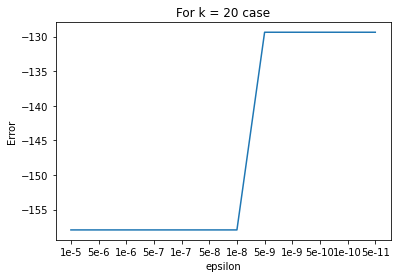

In [158]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 20, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 20, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case")
plt.show()

For $k = 20$, $1e-8$ is the turning point. For $\epsilon > 1e-8$, the error will increase greatly.

For $k  = 80$ and $S$, $M$ are k by k matrix

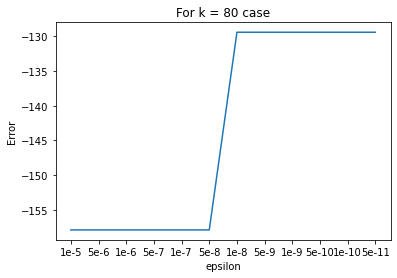

In [159]:
'''
Noiseless data
k = 80 for S, M(They are k by k matrix)
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 80, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 80, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case")
plt.show()

From the graph above of k = 80, we can see that if $\epsilon > 5e-8$. The error will increase greatly. $5e-8$ is the turning point which is greater than $1e-8$ for k = 20. It means we need to truncate more vectors in this case

For $k  = 160$ and $S$, $M$ are 160 by 160 matrix

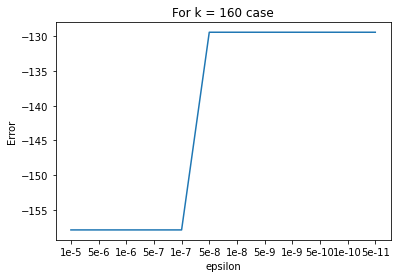

In [23]:
'''
Noiseless data
k = 160 for S, M(They are k by k matrix)
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 160, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 160, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 160 case")
plt.show()

From the graph above of k = 160, we can see that if $\epsilon > 1e-7$. The error will increase greatly. $1e-7$ is the turning point which is greater than $5e-8$ for k = 80. It means we need to truncate more vectors in this case than k = 80

For $k  = 320$ and $S$, $M$ are 320 by 320 matrix

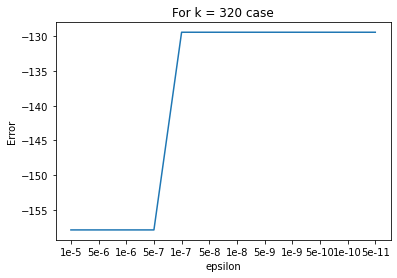

In [160]:
'''
Noiseless data
k = 160 for S, M(They are k by k matrix)
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 320, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 320, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 320 case")
plt.show()

From the graph above of k = 320, we can see that if $\epsilon > 5e-7$. The error will increase greatly. $1e-7$ is the turning point which is greater than $5e-8$ for k = 160. It means we need to truncate more vectors in this case than k = 160

From my experiments with noiseless data, I can conclude that if we increase $k$ then, we need greater $\epsilon$. It means that we need to truncate more vectors from $Z$

# 2.2 Data  with noise(Projection Framework)

Here Let's consider case with noise 5% and 10%
For case k = 20, 80, 160

In [127]:
s = np.random.uniform(-1,0,1)
noi_05 = s * 0.05
noi_1 = s * 0.1
print(s)

[-0.77986565]


For k = 20, Set my testing samples as 16

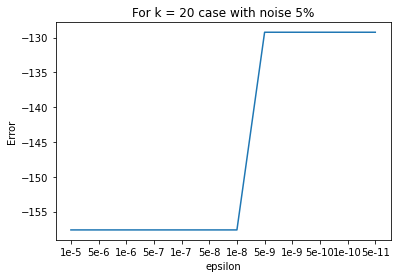

In [50]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 20, 16, 1, 3, ep, noi_05)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 20, 16, 1, 3, ep, noi_05)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case with noise 5%")
plt.show()

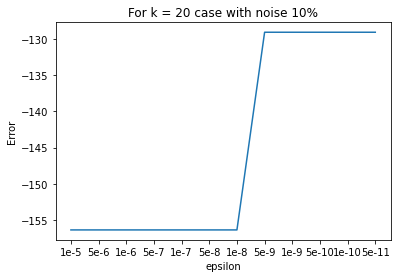

In [52]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
noise with 10%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 20, 16, 1, 3, ep, noi_1)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 20, 16, 1, 3, ep, noi_1)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case with noise 10%")
plt.show()

For k = 80, testing sample discretization $m = 16$

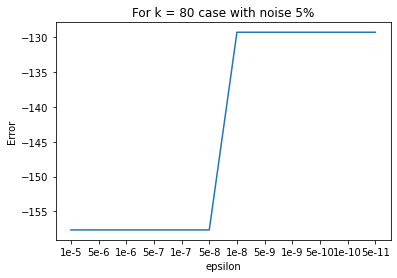

In [53]:
'''
Noiseless data
k = 80 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 80, 16, 1, 3, ep, noi_05)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 80, 16, 1, 3, ep, noi_05)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case with noise 5%")
plt.show()

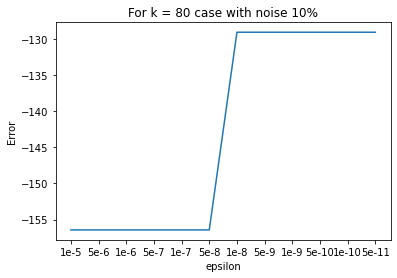

In [54]:
'''
Noiseless data
k = 80 for S, M
testing data discretization is m = 16
noise with 10%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 80, 16, 1, 3, ep, noi_1)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 80, 16, 1, 3, ep, noi_1)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case with noise 10%")
plt.show()

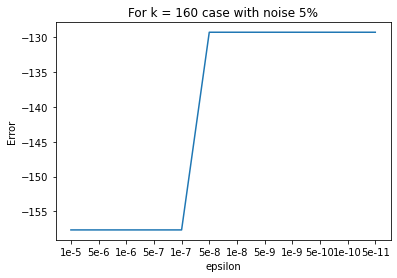

In [55]:
'''
Noiseless data
k = 160 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 160, 16, 1, 3, ep, noi_05)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 160, 16, 1, 3, ep, noi_05)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 160 case with noise 5%")
plt.show()

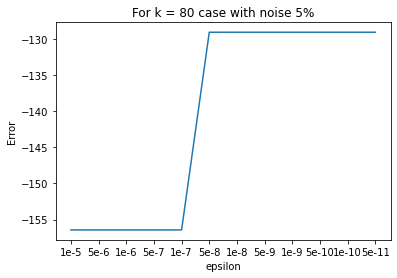

In [56]:
'''
Noiseless data
k = 160 for S, M
testing data discretization is m = 16
noise with 10%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-5','5e-6', '1e-6', '5e-7', '1e-7', '5e-8', '1e-8', '5e-9', '1e-9', '5e-10', '1e-10', '5e-11']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-5
y = np.array([log_error(action_matrix(101), 160, 16, 1, 3, ep, noi_1)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.5)
    else:
        ep = ep * (0.2)
    y[i] = log_error(action_matrix(101), 160, 16, 1, 3, ep, noi_1)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 160 case with noise 5%")
plt.show()

Conclusion: Noise does not affect the turning point for the error of cases k = 20, 80, 160. That's fantastic. I observe the same result as the noiseless data. That's fantastic. The result I have is that the greater $k$, the greater $\epsilon$ is better.

# 3.Noiseless data case(Loewner Framework)

For $n = 101$, $\lambda \in [1,3]$ <br>
Test matrix: A is 100 by 100 matrix <br>
$k = 20, 80, 160, 320$ <br>
$1e-5, 5e-6, 1e-6, 5e - 7...$ <br>
Noiseless data.

k = 20

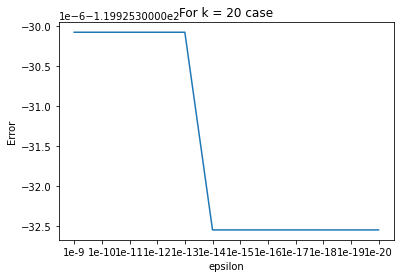

In [161]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
yy = np.array([-1 * i for i in range(12)])
kk = ['1e-9', '1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18','1e-19','1e-20', ]
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 20, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 20, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case")
plt.show()

k = 80

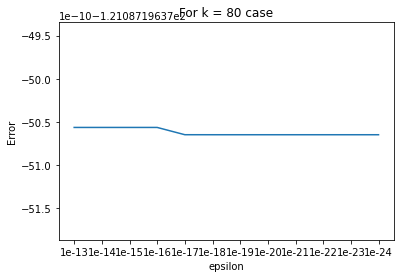

In [163]:
'''
Noiseless data
k = 80 for S, M
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
#yy = np.array([-8 * i for i in range(30)])
kk = ['1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19','1e-20','1e-21', '1e-22', '1e-23', '1e-24']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-13
y = np.array([log_error_L(action_matrix(101), 80, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 80, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case")
plt.show()

k = 160

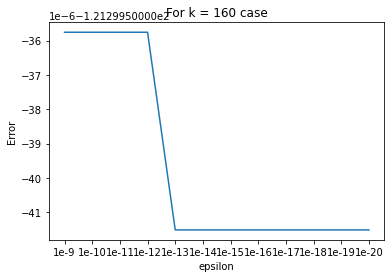

In [164]:
'''
Noiseless data
k = 160 for S, M
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9', '1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 160, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 160, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 160 case")
plt.show()

k = 320

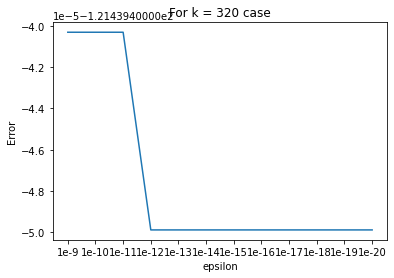

In [166]:
'''
Noiseless data
k = 320 for S, M
testing data discretization is m = 16
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9','1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 320, 16, 1, 3, ep, None)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 320, 16, 1, 3, ep, None)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 320 case")
plt.show()

The conclusion for Loewner Framework is: For greater k, smaller $\epsilon$ is always better than larger $\epsilon$

# 3.2 Noise data

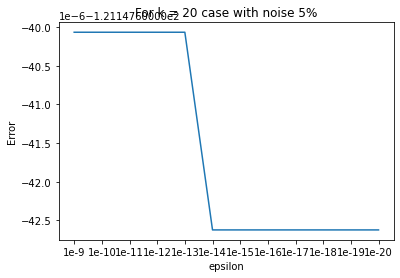

In [167]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9','1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 20, 16, 1, 3, ep, noi_05)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 20, 16, 1, 3, ep, noi_05)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case with noise 5%")
plt.show()

Error is obviously larger than noiseless one

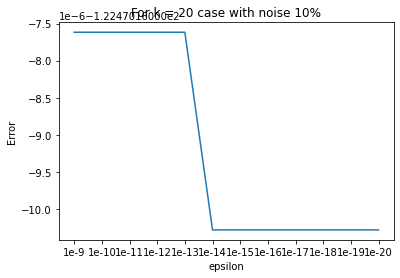

In [168]:
'''
Noiseless data
k = 20 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9','1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 20, 16, 1, 3, ep, noi_1)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 20, 16, 1, 3, ep, noi_1)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 20 case with noise 10%")
plt.show()

Error is obviously larger than noiseless one

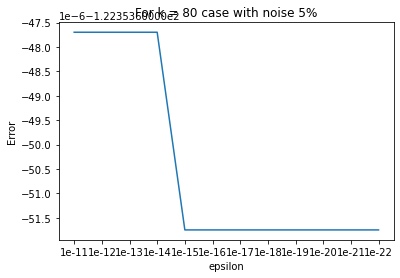

In [130]:
'''
Noiseless data
k = 80 for S, M
testing data discretization is m = 16
noise with 5%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9','1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 80, 16, 1, 3, ep, noi_05)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 80, 16, 1, 3, ep, noi_05)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case with noise 5%")
plt.show()

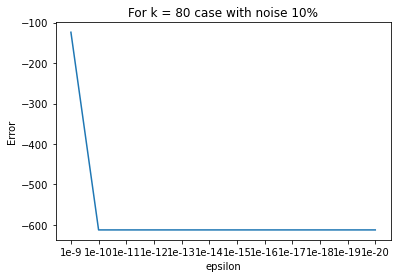

In [141]:
'''
Noiseless data
k = 80 for S, M
testing data discretization is m = 16
noise with 10%
'''
error = np.zeros(14)
cc = np.array([i for i in range(12)])
kk = ['1e-9','1e-10', '1e-11', '1e-12', '1e-13','1e-14', '1e-15', '1e-16', '1e-17', '1e-18', '1e-19', '1e-20']
plt.xticks(ticks=cc, labels=kk)
ep = 1e-9
y = np.array([log_error_L(action_matrix(101), 80, 16, 1, 3, ep, noi_1)] + [0]*11)
for i in range(1,12):
    if i%2 == 1:
        ep = ep * (0.1)
    else:
        ep = ep * (0.1)
    y[i] = log_error_L(action_matrix(101), 20, 80, 1, 3, ep, noi_1)

plt.plot(cc, y)
plt.xlabel("epsilon")
plt.ylabel("Error")
plt.title("For k = 80 case with noise 10%")
plt.show()

It's weird noise increase the accuracy for the estimation...